# Separation of Semantic Categories in A1 vs A2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
from scipy import stats
from spafe.features.lfcc import lfcc
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from frechetdist import frdist
import mantel

import os
import sys
import h5py
import warnings
warnings.filterwarnings("ignore")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
data_root = os.path.join('..', '..', 'data', 'anesthetized')
data_root

'..\\..\\data\\anesthetized'

In [3]:
df = pd.read_csv('aa-4.csv')
df.sample(n=5)

,subject,site,single_unit,sortType,stim_number,original_wavfile,callerAge,callid,stim_duration,stim_source,stim_source_sex,stim_type,brain_region,hemisphere,vocid,auditory_cortex
38,BlaBro09xxF,Site1,Site1_L1500R1500_e10_s0_ss1,single,232,WhiBlu4917_FAF_Th_10-4-8.wav,A,Th,2.500000,familiar,f,call,NCM,L,Th,A2
20449,GreBlu9508M,Site1,Site1_L750R1100_e31_s0_ss3,single,269,WhiLbl0010_MAS_Di_1.wav,A,Di,0.248505,unfamiliar,m,call,NCM,R,Di,A2
44078,GreBlu9508M,Site5,Site5_L1800R2100_e29_s0_ss2,single,258,WhiGra0114_FAF_Te_2-8-10.wav,A,Te,2.500000,familiar,f,call,L3,R,Te,A1
7887,BlaBro09xxF,Site2,Site2_L2000R1600_e30_s1_ss2,single,57,LblBlu1630_FCS_LT_4-10-9.wav,C,LT,2.500000,unfamiliar,f,call,L2B,R,LT,A1
39804,GreBlu9508M,Site4,Site4_L1500R1900_e8_s0_ss1,single,54,BlaBla0506_MAF_Th_4-5-2.wav,A,Th,2.500000,familiar,m,call,NCM,L,Th,A2


In [4]:
# returns a matrix of shape (n_trials, n_neurons)
# this is the SPIKE COUNT implementation
def getPopulationResponse(bird, stim_number, hemisphere='L', auditory_cortex='A1', end_time=1):
    resp_df = df[(df['subject']==bird) & (df['stim_number']==stim_number) & (df['hemisphere']==hemisphere) & (df['auditory_cortex']==auditory_cortex)]
    
    # load data
    cells = resp_df['single_unit'].unique()
    population_response = []
    
    # cell == neuron
    for cell in cells:
        # load cell
        source_path = os.path.join(data_root, bird, cell+'.h5')
        neuron_data = h5py.File(source_path)
        main_key = [k for k in neuron_data.keys() if k.__contains__('Call')][0]
        # load response
        cell_response = []
        try:
            trialIDs = neuron_data[main_key][str(stim_number)].keys()
        except:
            continue
        for i, trialID in enumerate(trialIDs):
            trial_response = neuron_data[main_key][str(stim_number)][trialID]['spike_times'][:].flatten()
            cell_response.append(((trial_response >= 0) & (trial_response <= end_time)).sum())
        
        cell_response = np.mean(cell_response)
        population_response.append(cell_response)
    population_response = np.array(population_response)
    return population_response

response = getPopulationResponse('GreBlu9508M', stim_number=102, end_time=1)
response

array([ 5.3       ,  4.8       ,  6.2       ,  7.9       ,  6.6       ,
        3.8       ,  9.7       ,  9.1       ,  4.8       , 17.9       ,
       11.1       ,  2.        ,  5.3       ,  1.9       ,  6.6       ,
        1.9       ,  9.9       ,  6.1       ,  0.7       , 27.4       ,
       32.6       , 55.        , 23.2       , 42.3       , 61.6       ,
       54.8       ,  0.2       ,  5.4       ,  2.1       ,  2.8       ,
        0.3       ,  7.6       , 11.9       , 14.6       ,  0.        ,
        8.18181818, 14.09090909, 36.        , 44.63636364, 16.27272727,
       53.81818182, 29.09090909, 15.45454545, 18.63636364, 18.36363636,
       21.5       , 29.7       , 26.4       ,  7.7       , 19.        ,
        5.2       ,  3.7       ,  4.6       , 33.4       , 27.3       ,
        6.2       , 18.4       ])

In [5]:
# returns a matrix X of shape (n_vocids, n_neurons)
def getSpikeCountsForStimuli(bird, hemisphere='L', auditory_cortex='A2'):
    resp_df = df[(df['subject']==bird) & (df['hemisphere']==hemisphere) & (df['auditory_cortex']==auditory_cortex)]
    vocids = resp_df['vocid'].unique()
    
    X, y = [], []
    for vocid in vocids:
        stimuli = resp_df[resp_df['vocid']==vocid]['stim_number'].unique()
        for stimulus in stimuli:
            stimulus_response = getPopulationResponse(bird, stimulus, hemisphere, auditory_cortex, end_time=1)
            X.append(stimulus_response)
            y.append(vocid+'_'+str(stimulus))
    return np.array(X), np.array(y)

In [6]:
# uncomment to calculate spike counts for every bird for every stimulus
'''for bird in df['subject'].unique():
    for hemisphere in ['L', 'R']:
        for auditory_cortex in ['A1', 'A2']:
            spike_counts, labels = getSpikeCountsForStimuli(bird, hemisphere, auditory_cortex)
            with open('spike_counts/'+bird+'_'+hemisphere+'_'+auditory_cortex+'_X.npy', 'wb') as f:
                np.save(f, spike_counts)
            with open('spike_counts/'+bird+'_'+hemisphere+'_'+auditory_cortex+'_y.npy', 'wb') as g:
                np.save(g, labels)'''

"for bird in df['subject'].unique():\n    for hemisphere in ['L', 'R']:\n        for auditory_cortex in ['A1', 'A2']:\n            spike_counts, labels = getSpikeCountsForStimuli(bird, hemisphere, auditory_cortex)\n            with open('spike_counts/'+bird+'_'+hemisphere+'_'+auditory_cortex+'_X.npy', 'wb') as f:\n                np.save(f, spike_counts)\n            with open('spike_counts/'+bird+'_'+hemisphere+'_'+auditory_cortex+'_y.npy', 'wb') as g:\n                np.save(g, labels)"

In [7]:
X = np.load('spike_counts/WhiWhi4522M_L_A1_X.npy')
y = np.load('spike_counts/WhiWhi4522M_L_A1_y.npy')

In [8]:
X.shape

(121, 9)

Text(0.5, 1.0, 'Spike-count vector')

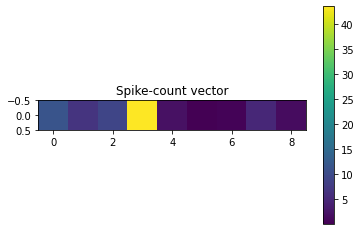

In [9]:
plt.imshow([(X[0])])
plt.colorbar()
plt.title('Spike-count vector')

In [10]:
def get_category_dist_matrix(X, y):
    X = normalize(X, axis=0)
    y = np.array([label[:label.find('_')] for label in y])
    unique_categories = np.unique(y)
    num_categories = len(unique_categories)
    dist_matrix = np.zeros((num_categories, num_categories))
    error_matrix = np.zeros((num_categories, num_categories))

    sample_labels = []
    category_indices = {}  # To keep track of the category indices and sample counts.
    
    # pick first category
    for i, cat_1 in enumerate(unique_categories):
        X_1 = X[y == cat_1]
        # pick second category
        for j, cat_2 in enumerate(unique_categories):
            X_2 = X[y == cat_2]
            
            distances = []
            # loop through X_1
            for sample_1 in X_1:
                # loop through X_2
                for sample_2 in X_2:
                    d = distance.cosine(sample_1, sample_2)
                    distances.append(d)
                    
            dist_matrix[i, j] = np.mean(distances)
            error_matrix[i, j] = np.std(distances)

    return dist_matrix, error_matrix

In [11]:
subject_table = df[['subject', 'hemisphere']].drop_duplicates()
subject_table = subject_table.reset_index()  # make sure indexes pair with number of rows

a1_dist_matrices, a1_err_matrices, a1_X, a1_y = [], [], [], []
a2_dist_matrices, a2_err_matrices, a2_X, a2_y = [], [], [], []
for i, row in subject_table.iterrows():
    a1_neurons = len(df[(df['subject']==row['subject'])&(df['hemisphere']==row['hemisphere'])&(df['auditory_cortex']=='A1')]['single_unit'].unique())
    a2_neurons = len(df[(df['subject']==row['subject'])&(df['hemisphere']==row['hemisphere'])&(df['auditory_cortex']=='A2')]['single_unit'].unique())
    neuron_count = a1_neurons if a1_neurons < a2_neurons else a2_neurons
    a1_dims, a2_dims = [], []
    data_dict = {
        'subject': row['subject'],
        'hemisphere': row['hemisphere'],
        'a1_neurons': a1_neurons,
        'a2_neurons': a2_neurons,
        'neuron_count': neuron_count
    }
    print(data_dict)
    
    if neuron_count == 0:
        continue
        
    print('Processing A1')
    X = np.load('spike_counts/' + row['subject'] + '_' + row['hemisphere'] + '_' + 'A1' + '_' + 'X.npy')
    y = np.load('spike_counts/' + row['subject'] + '_' + row['hemisphere'] + '_' + 'A1' + '_' + 'y.npy')
    cats = np.array([label[:label.find('_')] for label in y])
    X = X[np.isin(cats, ['Ag', 'Be', 'DC', 'Di', 'LT', 'Ne', 'Te', 'Th'])]
    y = y[np.isin(cats, ['Ag', 'Be', 'DC', 'Di', 'LT', 'Ne', 'Te', 'Th'])]
    
    a1_X.append(X)
    a1_y.append(y)
    
    a1_dist_matrix, a1_err_matrix = get_category_dist_matrix(X, y)
    a1_dist_matrices.append(a1_dist_matrix)
    a1_err_matrices.append(a1_err_matrix)
    
    print('Processing A2')
    X = np.load('spike_counts/' + row['subject'] + '_' + row['hemisphere'] + '_' + 'A2' + '_' + 'X.npy')
    y = np.load('spike_counts/' + row['subject'] + '_' + row['hemisphere'] + '_' + 'A2' + '_' + 'y.npy')
    cats = np.array([label[:label.find('_')] for label in y])
    X = X[np.isin(cats, ['Ag', 'Be', 'DC', 'Di', 'LT', 'Ne', 'Te', 'Th'])]
    y = y[np.isin(cats, ['Ag', 'Be', 'DC', 'Di', 'LT', 'Ne', 'Te', 'Th'])]
    
    a2_X.append(X)
    a2_y.append(y)
    
    a2_dist_matrix, a2_err_matrix = get_category_dist_matrix(X, y)
    a2_dist_matrices.append(a2_dist_matrix)
    a2_err_matrices.append(a2_err_matrix)

{'subject': 'BlaBro09xxF', 'hemisphere': 'L', 'a1_neurons': 8, 'a2_neurons': 43, 'neuron_count': 8}
Processing A1
Processing A2
{'subject': 'BlaBro09xxF', 'hemisphere': 'R', 'a1_neurons': 60, 'a2_neurons': 20, 'neuron_count': 20}
Processing A1
Processing A2
{'subject': 'GreBlu9508M', 'hemisphere': 'L', 'a1_neurons': 57, 'a2_neurons': 58, 'neuron_count': 57}
Processing A1
Processing A2
{'subject': 'GreBlu9508M', 'hemisphere': 'R', 'a1_neurons': 76, 'a2_neurons': 74, 'neuron_count': 74}
Processing A1
Processing A2
{'subject': 'LblBlu2028M', 'hemisphere': 'R', 'a1_neurons': 4, 'a2_neurons': 25, 'neuron_count': 4}
Processing A1
Processing A2
{'subject': 'LblBlu2028M', 'hemisphere': 'L', 'a1_neurons': 0, 'a2_neurons': 5, 'neuron_count': 0}
{'subject': 'WhiWhi4522M', 'hemisphere': 'L', 'a1_neurons': 9, 'a2_neurons': 64, 'neuron_count': 9}
Processing A1
Processing A2
{'subject': 'WhiWhi4522M', 'hemisphere': 'R', 'a1_neurons': 58, 'a2_neurons': 54, 'neuron_count': 54}
Processing A1
Processing 

In [12]:
np.mean(np.array(a1_dist_matrices), axis=0).shape

(8, 8)

In [13]:
for i in range(len(a1_y)):
    a1_y[i] = [label[:label.find('_')] for label in a1_y[i]]

In [14]:
for i in range(len(a2_y)):
    a2_y[i] = [label[:label.find('_')] for label in a2_y[i]]

In [15]:
a1_y = np.array(a1_y)

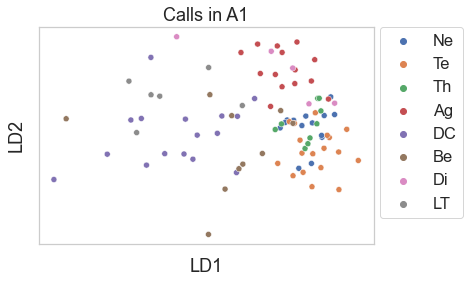

In [19]:
index = 5
lda = LinearDiscriminantAnalysis()
X = a1_X[index][:]
labels = a1_y[index][:]

a1_y[index] = np.array(a1_y[index])
scaler = MinMaxScaler()

X_scaled = normalize(X, axis=0)
A1_lda = lda.fit_transform(X_scaled, labels)
#print("explained variance:", pca.explained_variance_ratio_[:2])
#print("cross val score:", cross_val_score(lda, X_scaled, labels, cv=5))

plot = sns.scatterplot(x=A1_lda[:, 0], y=A1_lda[:, 1], hue=labels)
plot.set(xlabel='LD1', ylabel='LD2')
plot.set(xticklabels=[], yticklabels=[])
plot.tick_params(bottom=False, left=False)

sns.set(font_scale=1.5)
plt.title('Calls in A1')
sns.set_style("whitegrid", {'axes.grid' : False})
#sns.set_style("ticks")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

Text(0.5, 1.0, 'Calls in A2')

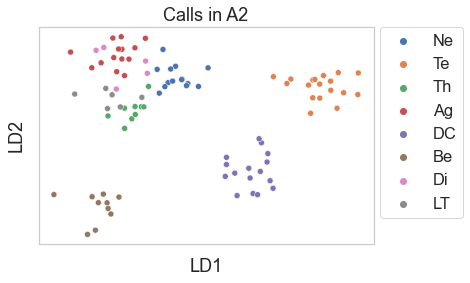

In [21]:
lda = LinearDiscriminantAnalysis()
X = a2_X[index][:]
labels = a2_y[index][:]

a2_y[index] = np.array(a2_y[index])
scaler = MinMaxScaler()

X_scaled = normalize(X, axis=0)
A2_lda = lda.fit_transform(X_scaled, labels)
#print("explained variance:", pca.explained_variance_ratio_[:2])
#print("cross val score:", cross_val_score(lda, X_scaled, labels, cv=5))

plot = sns.scatterplot(x=A2_lda[:, 0], y=A2_lda[:, 1], hue=labels)
plot.set(xlabel='LD1', ylabel='LD2')
plot.set(xticklabels=[], yticklabels=[])
plot.tick_params(bottom=False, left=False)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title('Calls in A2')

['Ag' 'Be' 'DC' 'Di' 'LT' 'Ne' 'Te' 'Th']


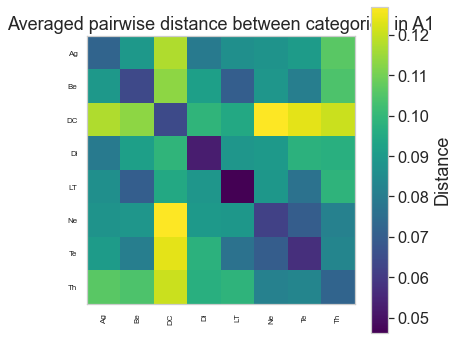

In [22]:
# Increase the size of the plot
plt.figure(figsize=(6, 6))

# Plot the distance matrix
plt.imshow(np.mean(np.array(a1_dist_matrices), axis=0), cmap='viridis')

# Set ticks and labels
cats = np.unique(np.array([label[:label.find('_')] for label in y]))
print(cats)
cats = cats[cats != 'song']
plt.xticks(np.arange(len(cats)), cats, rotation=90, fontsize=8)
plt.yticks(np.arange(len(cats)), cats, fontsize=8)

# Add colorbar
plt.colorbar(label='Distance')
plt.title('Averaged pairwise distance between categories in A1')

# Show the plot
plt.show()

In [23]:
cats = np.unique(cats)
sep_a1, sep_a2 = [], []
for hemisphere in range(9):
    
    within_cat, across_cat = [], []
    A1 = np.array(a1_dist_matrices[hemisphere])
    A1_err = np.array(a1_err_matrices[hemisphere])
    
    for i, cat in enumerate(cats):
        within_cat.append(A1[i, i])
        across_cat.append(((np.sum(A1[i, :]) - A1[i, i])) / 7)
        within_err = A1_err[i, i]

    sep_a1.append((np.array(across_cat) - np.array(within_cat)) / np.array(within_err))
    
    
    within_cat, across_cat = [], []
    A2 = np.array(a2_dist_matrices[hemisphere])
    A2_err = np.array(a2_err_matrices[hemisphere])
    for i, cat in enumerate(cats):
        within_cat.append(A2[i, i])
        across_cat.append(((np.sum(A2[i, :]) - A2[i, i])) / 7)
        within_err = A2_err[i, i]
        
    sep_a2.append((np.array(across_cat) - np.array(within_cat)) / np.array(within_err))
    #print("sep_a1:", sep_a1[hemisphere])
    #print("sep_a2:", sep_a2[hemisphere])
    #print(stats.wilcoxon(sep_a1[hemisphere], sep_a2[hemisphere], alternative='less'))
    #print()

In [24]:
sep_a1

[array([0.4628568 , 0.29248422, 0.84924786, 0.40516269, 0.7007798 ,
        0.43929642, 0.63172779, 0.78162264]),
 array([0.5552022 , 0.46777067, 0.04602686, 0.64508733, 0.52128813,
        0.25328502, 0.28684821, 0.31285668]),
 array([0.70995623, 0.70149462, 0.69512366, 0.75988671, 0.71422635,
        0.28129819, 0.4622177 , 0.68193556]),
 array([-0.01048078,  0.27549907,  0.87370148,  0.48185169,  0.4288339 ,
         0.43172607,  0.37825459,  0.16642295]),
 array([ 0.10503559,  0.23407333,  0.19131608,  0.3877641 ,  0.1418132 ,
         0.0388662 ,  0.14139402, -0.04562842]),
 array([0.44326746, 0.47284624, 0.62819084, 1.07213229, 2.21651934,
        1.34713881, 1.107929  , 1.2510424 ]),
 array([0.98683791, 1.2049228 , 1.04354348, 0.98094232, 1.59205234,
        1.22852265, 1.11622055, 1.75168104]),
 array([0.59710893, 1.39786144, 3.46482752, 1.44585042, 1.53690369,
        1.24963176, 1.44630089, 1.20345933]),
 array([0.24851407, 0.1142583 , 0.52682651, 0.45735471, 0.31254983,
    

In [25]:
sep_a2

[array([0.42255121, 0.34084338, 0.32444658, 0.24670029, 0.2379388 ,
        0.35224922, 0.10537536, 0.11778178]),
 array([1.79544608, 0.38188874, 2.20012218, 1.49798063, 0.96446169,
        1.0267193 , 1.36075423, 1.72052927]),
 array([1.43334603, 1.22975192, 1.14336865, 0.9703616 , 1.46272166,
        1.79404917, 0.84721654, 1.45157069]),
 array([1.32346668, 1.23722492, 1.52357128, 0.82415837, 0.96285596,
        1.00126798, 0.71954944, 1.43407986]),
 array([1.04666605, 0.94524619, 1.11118049, 1.23984388, 2.20467598,
        0.61358366, 1.28477757, 1.35169476]),
 array([0.8563923 , 0.82361226, 0.89014419, 1.07664576, 0.89861578,
        1.28796387, 1.39362566, 1.56417766]),
 array([2.13955684, 0.85826823, 2.03955166, 2.15232744, 3.44370753,
        1.4383211 , 2.60530203, 2.73033887]),
 array([0.50652907, 0.48186282, 0.89511655, 0.80119741, 0.74359026,
        0.44611543, 0.62981087, 0.37064697]),
 array([0.58901533, 0.54375183, 0.9634779 , 0.98644169, 0.94493963,
        0.68793014, 

In [26]:
sep_a1 = np.array(sep_a1)
sep_a2 = np.array(sep_a2)

In [54]:
stats.wilcoxon(np.mean(sep_a2, axis=0), np.mean(sep_a1, axis=0), alternative='greater')

WilcoxonResult(statistic=36.0, pvalue=0.00390625)

### Plotting

Text(0.5, 1.0, 'Separation of Calls in A1 vs A2')

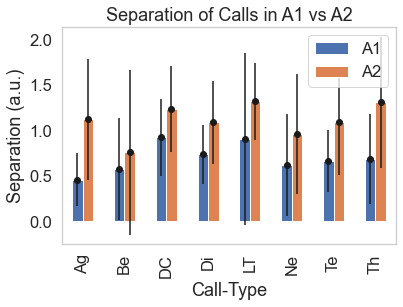

In [58]:
# create dataframe
index = np.unique(labels)
df = pd.DataFrame({'A1': np.mean(sep_a1, axis=0), 'A2': np.mean(sep_a2, axis=0)}, index=index)

# plot
ax = df.plot.bar()

X, W, H = [], [], []
for p in ax.patches:
    X.append(p.get_x() + p.get_width()/2)  # get the bottom left x corner of the bar
    W.append(p.get_width())  # get width of bar
    H.append(p.get_height())  # get height of bar
    
errors = [item for pair in zip(np.std(sep_a1, axis=0), np.std(sep_a2, axis=0)) for item in pair]
plt.errorbar(X, H, yerr=errors, fmt='o', color='k')
plt.xlabel('Call-Type')
plt.ylabel('Separation (a.u.)')
plt.title('Separation of Calls in A1 vs A2')